# 1 - Introduction

Dataset : Historical prices of gold (XAUUSD) from Yahoo Finance

# 2 - Importing Libraries

In [26]:
import math
import pickle
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objects as go
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# 3 - Data Loading

Upgrade pandas dan pandas-datareader.

In [2]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Deklarasikan nama quote instrumen keuangan.

In [3]:
quote = 'GC=F' # Symbols  untuk gold di Yahoo Finance

Membuat variabel tanggal terbaru hari ini.

In [36]:
today = date.today()
print("Today's date:", today)

Today's date: 2022-06-06


Membaca data dari yahoo dengan tanggal awal dan akhir yang ditentukan.

In [37]:
df = web.DataReader(quote,
                    data_source='yahoo',
                    start='2002-01-01',
                    end=today)

Overview data.

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-01-02,278.899994,278.899994,278.899994,278.899994,2.0,278.899994
2002-01-03,278.200012,278.200012,278.200012,278.200012,2.0,278.200012
2002-01-04,278.899994,278.899994,278.899994,278.899994,2.0,278.899994
2002-01-07,279.000000,278.600006,278.600006,278.600006,1.0,278.600006
2002-01-08,278.899994,278.899994,278.899994,278.899994,1.0,278.899994


Cek bentuk data.

In [ ]:
df.shape

(5130, 6)

Menampilkan data historikal harga penutupan emas.

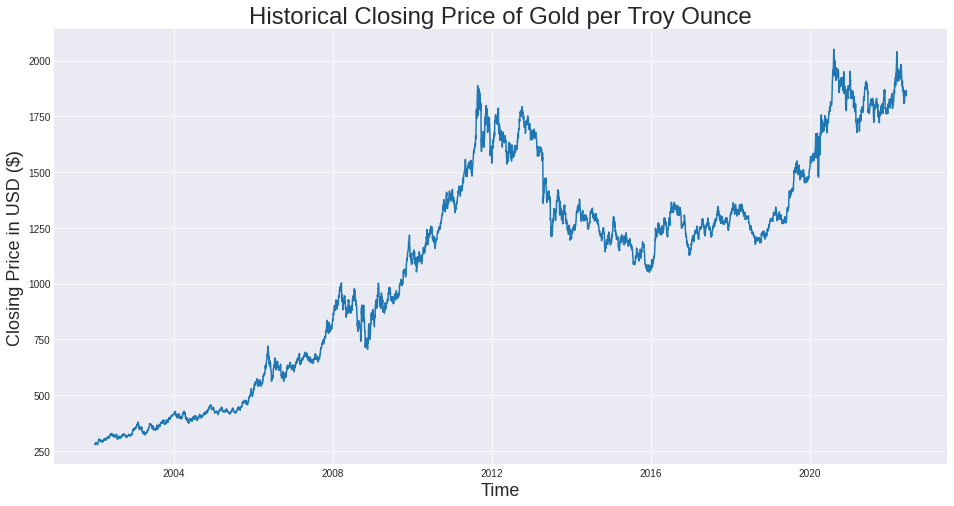

In [ ]:
plt.figure(figsize=(16,8))
plt.title(f'Historical Closing Price of Gold per Troy Ounce', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Closing Price in USD ($)', fontsize=18)
plt.show()

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# 4 - Exploratory Data Analysis (EDA)

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-01-02,278.899994,278.899994,278.899994,278.899994,2.0,278.899994
2002-01-03,278.200012,278.200012,278.200012,278.200012,2.0,278.200012
2002-01-04,278.899994,278.899994,278.899994,278.899994,2.0,278.899994
2002-01-07,279.000000,278.600006,278.600006,278.600006,1.0,278.600006
2002-01-08,278.899994,278.899994,278.899994,278.899994,1.0,278.899994


Cek ringkasan deskripsi data.

In [ ]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,5130.000000,5130.000000,5130.000000,5130.000000,5130.000000,5130.000000
mean,1109.612632,1097.994542,1103.992905,1103.887407,4568.868616,1103.887407
std,483.230606,477.336174,480.413751,480.345865,25392.710442,480.345865
min,278.100006,278.100006,278.100006,278.100006,0.000000,278.100006
25%,656.874985,652.700012,654.199997,654.000015,22.000000,654.000015
50%,1222.199951,1209.599976,1215.350037,1216.599976,107.000000,1216.599976
75%,1421.300049,1405.800049,1414.300018,1414.750031,397.000000,1414.750031
max,2072.000000,2040.000000,2053.600098,2051.500000,386334.000000,2051.500000


Harga all time high terjadi pada tanggal 08-03-2022 di harga 2072 USD per oz.

In [ ]:
all_time_high = df.describe().loc['max']['High']
df[df['High'] == all_time_high]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-03-08,2072.0,1998.0,1999.400024,2040.099976,1813.0,2040.099976


Harga all time low terjadi pada tanggal 24-01-2002 di harga 278.1 USD per oz.

In [ ]:
all_time_low = df.describe().loc['min']['Low']
df[df['Low'] == all_time_low]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-01-24,278.100006,278.100006,278.100006,278.100006,2.0,278.100006


Volume perdagangan/transaksi terbesar adalah sebanyak 386,334 lot atau sebesar 38,633,400 oz dengan kontrak 100 oz per lot.

In [ ]:
highest_vol = df.describe().loc['max']['Volume']
df[df['Volume'] == highest_vol]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-05-29,1298.699951,1298.699951,1298.699951,1298.699951,386334.0,1298.699951


Return gain tertinggi antara harga all time high dan all time low.

In [ ]:
high_low_gain = df.describe().loc['max']['Close']/df.describe().loc['min']['Close']

print(f'Biggest Return Between Highest and Lowest Price : {(high_low_gain - 1)*100:.2f}%')

Biggest Return Between Highest and Lowest Price : 637.68%


# 5 - Data Preprocessing

Memilih hanya kolom `close`.

In [27]:
data = df.filter(['Close'])
data

,Close
Date,
2002-01-02,278.899994
2002-01-03,278.200012
2002-01-04,278.899994
2002-01-07,278.600006
2002-01-08,278.899994
...,...
2022-05-27,1851.300049
2022-05-31,1842.699951
2022-06-01,1843.300049


Mengambil valuenya saja.

In [28]:
dataset = data.values

dataset

array([[ 278.8999939 ],
       [ 278.20001221],
       [ 278.8999939 ],
       ...,
       [1843.30004883],
       [1866.5       ],
       [1845.40002441]])

Menghitung banyak data untuk training dengan proporsi training 0.8 dari total data.

In [29]:
#Split data into 0.8 for training and 0.2 for testing
training_data_len = math.ceil(len(dataset)*0.8)

training_data_len

4104

### Scaling data

Split data menjadi train dan test dengan jumlah yang telah dihitung sebelumnya 

In [30]:
train_data = dataset[:training_data_len]
test_data = dataset[training_data_len:]

train_data.shape, test_data.shape

((4104, 1), (1025, 1))

Scalling data menggunakan minmax scaler.

In [32]:
scaler = Pipeline([
                   ('scaler', MinMaxScaler())
])

scaler.fit(train_data)
train_scaled_data = scaler.transform(train_data)
test_scaled_data = scaler.transform(test_data)

In [35]:
# simpan scaler
with open("gold_scaler.pkl", "wb") as f:
  pickle.dump(scaler, f)

In [33]:
train_scaled_data

array([[4.96701739e-04],
       [6.20924543e-05],
       [4.96701739e-04],
       ...,
       [6.41934701e-01],
       [6.41500110e-01],
       [6.47398534e-01]])

In [34]:
test_scaled_data

array([[0.64628091],
       [0.64472869],
       [0.62759223],
       ...,
       [0.97181181],
       [0.98621635],
       [0.97311565]])

### Data Training Preparation

Menyiapkan fitur dan label untuk data training. 

* Fitur x adalah data harga yang dipilih sebanyak n_days.
$$ x_{t-1},  x_{t-2},  x_{t-3}, ..., x_{t-n}$$
* Label y adalah data harga yang merupakan kombinasi linier dari sejumlah n_days fitur pada data sebelumnya.
$$y=x_t=w_1 x_{t-1} + w_2 x_{t-2} + w_3 x_{t-3} + ... + w_n x_{t-n}$$

In [ ]:
x_train = [] # Buat list kosong u/ menampung data
y_train = []
n_days = 40

for i in range(n_days, len(train_data)):
  # Data awal hingga n_days data ke depan menjadi x_train
  x_train.append(train_scaled_data[i-n_days:i, 0])
  # Data ke n_days menjadi y_train
  y_train.append(train_scaled_data[i, 0])
  # Cek data pertama untuk fitur dan label 
  if i <=n_days:
    print(x_train)
    print(y_train)

[array([4.96701739e-04, 6.20924543e-05, 4.96701739e-04, 3.10443324e-04,
       4.96701739e-04, 3.29069165e-03, 5.58797983e-03, 5.77423824e-03,
       4.53246495e-03, 3.91157830e-03, 5.71214579e-03, 3.91157830e-03,
       3.10443324e-03, 2.11101081e-03, 3.10443324e-04, 0.00000000e+00,
       4.34609284e-04, 1.24165961e-04, 2.04891836e-03, 2.35936168e-03,
       2.48354659e-03, 4.90500072e-03, 6.95391908e-03, 1.24798254e-02,
       1.20451972e-02, 1.34111554e-02, 1.57705171e-02, 1.36595062e-02,
       1.40320420e-02, 1.32248780e-02, 1.34111554e-02, 1.26039914e-02,
       9.37539216e-03, 8.81657902e-03, 9.37539216e-03, 9.37539216e-03,
       9.06494884e-03, 1.23556405e-02, 1.13001256e-02, 1.15484954e-02])]
[0.012355640491245462]


Jumlah train_data = (jumlah `x_train` atau jumlah `y_train`) + `n_days`

In [ ]:
x_test = [] # Buat list kosong u/ menampung data
y_test = []

for i in range(n_days, len(test_data)):
  # Data awal hingga n_days data ke depan menjadi x_test
  x_test.append(test_scaled_data[i-n_days:i, 0])
  # Data ke n_days menjadi y_test
  y_test.append(test_scaled_data[i, 0])

Mengubah menjadi numpy array.

In [ ]:
# Mengubah data menjadi format numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

# Mengubah data menjadi format numpy array
x_test, y_test = np.array(x_test), np.array(y_test)

In [ ]:
x_train.shape, x_test.shape

((4064, 40), (986, 40))

Mengubah dimensi data x menjadi 3D.

In [ ]:
# Mengubah dimensi data train menjadi 3 dimensi karena LSTM butuh data berdimensi 3
x_train = np.reshape(x_train, 
    (x_train.shape[0],
    x_train.shape[1],
    1
))
x_train.shape

(4064, 40, 1)

In [ ]:
# Mengubah x test menjadi 3 dimensi
x_test = np.reshape(x_test,
                    (x_test.shape[0],
                     x_test.shape[1],
                     1))

# 6 - Model Definition

Membangun arsitektur time series dengan konfigurasi sebagai berikut:
1. Model Sequential
2. 2 Layer LSTM dengan jumlah masing-masing 50 dan input sebanyak n_days
3. Hidden layer sebanyak 25 neuron
4. Output layer sebanyak 1 neuron

In [ ]:
# Architecture for Neural Network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(units=25))

model.add(Dense(1))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 40, 50)            10400     
                                                                 
 lstm_40 (LSTM)              (None, 50)                20200     
                                                                 
 dense_39 (Dense)            (None, 25)                1275      
                                                                 
 dense_40 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


Compile model dengan optimizer adam dan loss mean squared error.

In [ ]:
#Compile the architecture
model.compile(optimizer='adam', loss='mean_squared_error')

Membuat callback dengan early stopping ketika tidak mengalami optimisasi pada 4 epoch berikutnya dan dengan model checkpoint untuk menyimpan model terbaik.

In [ ]:
# callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', mode= 'min', patience=4, verbose=1),
    ModelCheckpoint('ts_gold.hdf5', monitor='val_loss', save_best_only=True)
]

# 7 - Model Training

Training model pada data `x_train` terhadap `y_train` dengan 32 data batch dan epoch 100 kali.

In [ ]:
history = model.fit(
    x=x_train, 
    y=y_train, 
    validation_data=(x_test, y_test),
    batch_size=32,
    callbacks=callbacks, 
    epochs=100
)

Epoch 1/100
127/127 [==============================] - 9s 44ms/step - loss: 0.0105 - val_loss: 4.9038e-04
Epoch 2/100
127/127 [==============================] - 5s 37ms/step - loss: 3.3770e-04 - val_loss: 6.1920e-04
Epoch 3/100
127/127 [==============================] - 5s 37ms/step - loss: 3.4813e-04 - val_loss: 4.4877e-04
Epoch 4/100
127/127 [==============================] - 5s 37ms/step - loss: 3.1165e-04 - val_loss: 4.1761e-04
Epoch 5/100
127/127 [==============================] - 5s 36ms/step - loss: 3.3549e-04 - val_loss: 0.0010
Epoch 6/100
127/127 [==============================] - 5s 37ms/step - loss: 2.9574e-04 - val_loss: 8.7076e-04
Epoch 7/100
127/127 [==============================] - 5s 37ms/step - loss: 2.8443e-04 - val_loss: 3.8854e-04
Epoch 8/100
127/127 [==============================] - 5s 37ms/step - loss: 2.6704e-04 - val_loss: 6.3466e-04
Epoch 9/100
127/127 [==============================] - 5s 36ms/step - loss: 2.8623e-04 - val_loss: 5.3665e-04
Epoch 10/100
127/1

# 8 - Model Evaluation

Membuat fungsi untuk menampilkan grafik loss terhadap epoch.

In [ ]:
def loss(data_result):
    plt.figure(figsize=(7, 5))
    plt.plot(np.arange(1, 1+len(data_result)), data_result['loss'])
    plt.plot(np.arange(1, 1+len(data_result)), data_result['val_loss'])
    plt.title('Loss', fontsize=16, loc='center', color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(labels=['loss', 'val_loss'])

    plt.tight_layout()
    plt.show()

Menampilkan grafik loss model

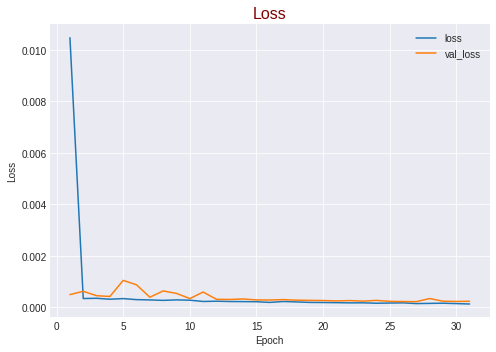

In [ ]:
result = pd.DataFrame(history.history) # Membuat dataframe dari histori model
loss(result)

### Data Test Prediction

Melakukan prediksi terhadap `x_test` dengan model yang sudah ditraining.

In [ ]:
predictions = model.predict(x_test)

# mengembalikan lagi ke nilai awal (tidak di scaling)
predictions = scaler.inverse_transform(predictions)

In [ ]:
predictions.shape

(986, 1)

Unscalling data `y_test`.

In [ ]:
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

Cek nilai Root Mean Square Error dan Mean Absolute Percentage Error.

In [ ]:
rmse = (metrics.mean_squared_error(y_test_unscaled, predictions))**0.5
mape = metrics.mean_absolute_percentage_error(y_test_unscaled, predictions)
print(f'Error yang terjadi sekitar ${rmse:.2f} dengan persentase relatif {mape*100:.2f}%')

Error yang terjadi sekitar $24.52 dengan persentase relatif 1.05%


### Visualize the Prediction

In [ ]:
pred_addnan = np.concatenate((np.nan*np.ones(n_days), predictions[:, 0])) #1062 + np.nan*n_days
pred_addnan.shape

(1026,)

In [ ]:
# Membuat dataframe
train = df.filter(['Close'])[:training_data_len]
valid = df.filter(['Close'])[training_data_len:] #1092
valid['Predictions'] = pred_addnan 

In [ ]:
valid

,Close,Predictions
Date,,
2018-05-11,1319.000000,NaN
2018-05-14,1316.500000,NaN
2018-05-15,1288.900024,NaN
2018-05-16,1290.199951,NaN
2018-05-17,1288.199951,NaN
...,...,...
2022-05-31,1842.699951,1844.627075
2022-06-01,1843.300049,1839.384521
2022-06-02,1866.500000,1834.402344


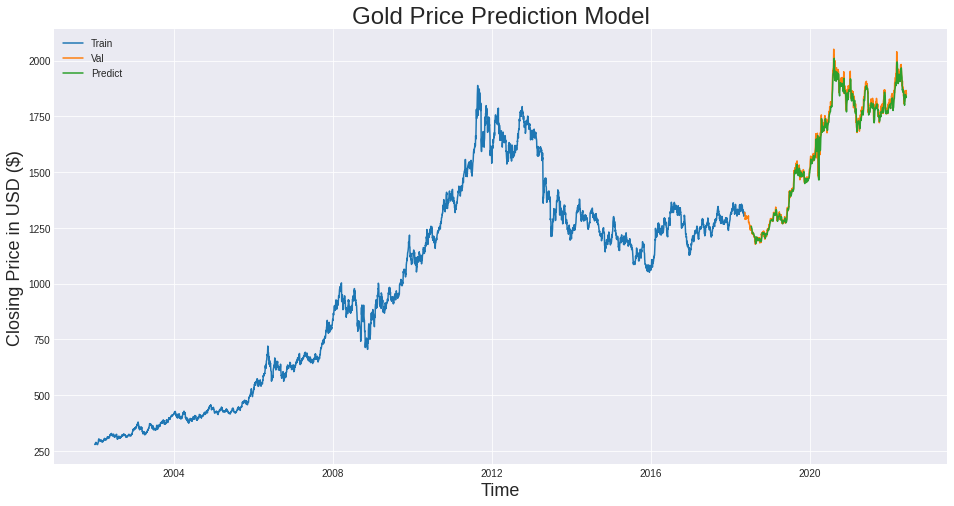

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Gold Price Prediction Model', fontsize=24)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Closing Price in USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predict'])
plt.show()

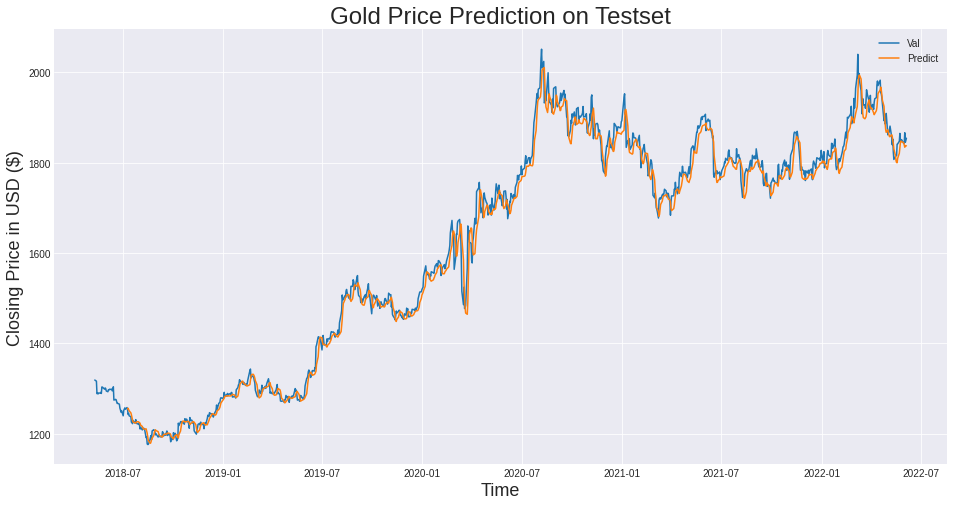

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Gold Price Prediction on Testset', fontsize=24)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Closing Price in USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predict'])
plt.show()

* Memprediksi hari berikutnya dengan fitur sebanyak `n_days` data terakhir dan menggunakan model yang di training pada data train.

In [ ]:
x_next_day = x_test[-1].reshape(1, n_days, 1)
next_day = model.predict(x_next_day)
# Unscalling
next_day = scaler.inverse_transform(next_day)

In [ ]:
next_day[0,0]

1837.421

In [ ]:
def predict_result(last_price_data, predict_price_data):

  last_price = last_price_data[-1, 0]
  next_price = predict_price_data[0,0]

  if last_price < next_price:
    print(f'Up --> {(next_price/last_price - 1)*100:.2f}%')
    print(f'Prediction Price : $ {next_price:.2f}/oz')
  else:
    print(f'Down --> {(next_price/last_price - 1)*100:.2f}%')
    print(f'Prediction Price : $ {next_price:.2f}/oz')

In [ ]:
predict_result(dataset, next_day)

Down --> -0.92%
Prediction Price : $ 1837.42/oz


### Training All Data

In [ ]:
scaler_all = MinMaxScaler()
scaled_data = scaler_all.fit_transform(dataset)

x = []
y = []

for i in range(n_days, len(scaled_data) - n_days):
  x.append(scaled_data[i-n_days:i, 0])
  y.append(scaled_data[i, 0])
	
#mengubah data menjadi format numpy array
x_train_all, y_train_all = np.array(x), np.array(y)

#mengubah dimensi data train menjadi 3 dimensi karena LSTM butuh data berdimensi 3
# [number of samples, number of time steps, and number of features]
x_train_all = np.reshape(x_train_all, (
    x_train_all.shape[0],
    x_train_all.shape[1],
    1
))

#Build Architecture for Neural Network
model_all = Sequential()
model_all.add(LSTM(50, return_sequences=True, input_shape=(x_train_all.shape[1], 1)))
model_all.add(LSTM(50, return_sequences=False))
model_all.add(Dense(units=25))
model_all.add(Dense(1))

#Compile the architecture
model_all.compile(optimizer='adam', loss='mean_squared_error')

callbacks_all = [
    EarlyStopping(monitor= 'loss', mode= 'min', patience=4, verbose=1),
    ModelCheckpoint('ts_all_gold.hdf5', monitor='loss', save_best_only=True)
]

model_all_history = model_all.fit(
  x_train_all, 
  y_train_all, 
  batch_size=32, 
  callbacks=callbacks_all,
  epochs=100
)

Epoch 1/100
158/158 [==============================] - 11s 43ms/step - loss: 0.0086
Epoch 2/100
158/158 [==============================] - 7s 42ms/step - loss: 2.9632e-04
Epoch 3/100
158/158 [==============================] - 7s 42ms/step - loss: 2.9162e-04
Epoch 4/100
158/158 [==============================] - 7s 42ms/step - loss: 2.7240e-04
Epoch 5/100
158/158 [==============================] - 7s 41ms/step - loss: 2.8823e-04
Epoch 6/100
158/158 [==============================] - 6s 41ms/step - loss: 2.4896e-04
Epoch 7/100
158/158 [==============================] - 6s 41ms/step - loss: 2.2468e-04
Epoch 8/100
158/158 [==============================] - 7s 41ms/step - loss: 2.1238e-04
Epoch 9/100
158/158 [==============================] - 7s 41ms/step - loss: 2.1776e-04
Epoch 10/100
158/158 [==============================] - 7s 42ms/step - loss: 2.0603e-04
Epoch 11/100
158/158 [==============================] - 7s 42ms/step - loss: 1.9598e-04
Epoch 12/100
158/158 [======================

In [ ]:
x_last = scaled_data[-n_days:, 0]

x_last

array([0.93802863, 0.93955117, 0.95522723, 0.96024586, 0.95455059,
       0.96131726, 0.94597945, 0.94406228, 0.93988949, 0.93205143,
       0.91073641, 0.91536034, 0.90662007, 0.90819891, 0.91981507,
       0.89303036, 0.89697758, 0.89596256, 0.89990978, 0.90396975,
       0.89038005, 0.88068119, 0.88784255, 0.8716026 , 0.86235481,
       0.86579452, 0.86844477, 0.86714786, 0.8814142 , 0.88175259,
       0.88513592, 0.89489116, 0.88423365, 0.88491036, 0.88710953,
       0.88226004, 0.88259843, 0.89568061, 0.88378258, 0.88885758])

In [ ]:
pred_next_day = model_all.predict(x_last.reshape(1, n_days, 1))
pred_next_day_price = scaler_all.inverse_transform(pred_next_day)

In [ ]:
predict_result(dataset, pred_next_day_price)

Up --> 0.95%
Prediction Price : $ 1872.09/oz


# 9 - Model Saving

Model telah disave dengan menggunakan model checkpoint pada callback.

# 10 - Model Inference

Membuat data random yang nilainya sekitar `n_days` data terakhir dari dataset.

In [ ]:
a = np.random.normal(1, 0.01, size=(n_days, 1))

x_inf = a*dataset[-n_days:]

Scalling data inference.

In [ ]:
x_inf_scaled = scaler.transform(x_inf)

Load model.

In [ ]:
best_model = load_model('ts_all_gold.hdf5')

Prediksi data inference

In [ ]:
pred_inf = best_model.predict(x_inf_scaled.reshape(1, n_days, 1))
pred_inf_price = scaler.inverse_transform(pred_inf)

In [ ]:
predict_result(x_inf, pred_inf_price)

Down --> -0.90%
Prediction Price : $ 1817.90/oz


# 11 - Conclusion

1. Dataset yang digunakan adalah data dari Yahoo Finance.
3. Dataset dibagi menjadi 2 bagian yaitu: 
    - Trainset  : 4104 data (80%)
    - Valset/Testset    : 1026 data (20%)
4. Jumlah fitur yang digunakan adalah 40 data.

6. Arsitektur neural network yang dibangun adalah sebagai berikut:
    - Model sequential.
    - Terdapat 2 layer LSTM dengan jumlah masing-masing 50 neuron.
    - Terdapat 1 hidden layer dengan 25 neuron.
    - Terdapat 1 neuron output.
    - Model dicompile dengan optimizer adam dan loss mean squared error.
    
8. Model terbaik yang didapatkan menghasilkan loss sebesar 1.4268e-04 dan validasi loss sebesar 2.1719e-04 dengan nilai Root Mean Square Error pada testset adalah $24.52.